In [1]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import os, sys
from pprint import pprint
sys.path.extend(('../reframe', '..')) # the `modules` package imports `reframe` so need that in sys.modules
import modules
import reframe_imb

In [2]:
# NB: this is based on paths looking like:
# ../output/alaska/compute-roce/gnu-openmpi/IMB_PingPong/rfm_IMB_PingPong_job.out 
# ../perflogs/alaska/compute-roce/gnu-openmpi/IMB_PingPong/IMB_PingPong.log

In [3]:
# find and load output files:
run_outputs = modules.utils.find_run_outputs('../output', 'IMB')

# load results using the same function that we use for reframe performance tests:
results = []
for path in run_outputs:
    result = reframe_imb.read_imb_out(path)
    results.append(result)

# Group results by *testname*
test_results = modules.utils.group_by(results, lambda x: x['meta']['testname'])

print('loaded %s output files from %i tests' % (len(results), len(test_results)))
for test, cases in test_results.items():
    print(test, ':')
    for c in cases:
        print('  ', c['meta']['path'])
#         print('    ',c['meta']['environ'])
#         print('    ',c['meta']['partition'])

loaded 5 output files from 3 tests
IMB_Uniband :
   ../output/p4/ib-openmpi3-openib/imb/IMB_Uniband/rfm_IMB_Uniband_job.out
   ../output/p4/roce-openmpi3-openib/imb/IMB_Uniband/rfm_IMB_Uniband_job.out
IMB_PingPong :
   ../output/p4/ib-openmpi3-openib/imb/IMB_PingPong/rfm_IMB_PingPong_job.out
   ../output/p4/roce-openmpi3-openib/imb/IMB_PingPong/rfm_IMB_PingPong_job.out
IMB_Biband :
   ../output/p4/roce-openmpi3-openib/imb/IMB_Biband/rfm_IMB_Biband_job.out


No handles with labels found to put in legend.


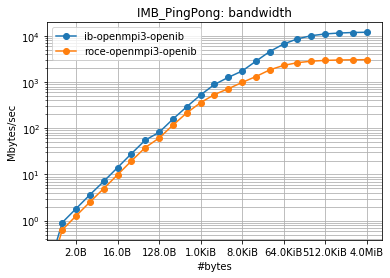

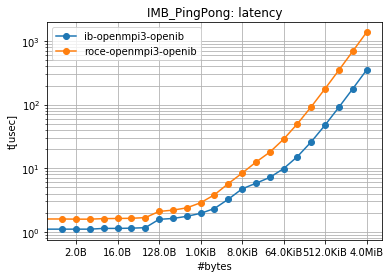

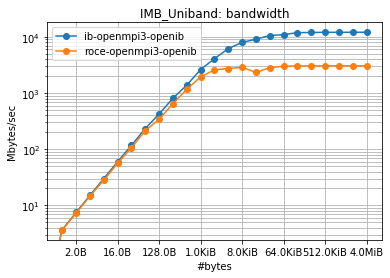

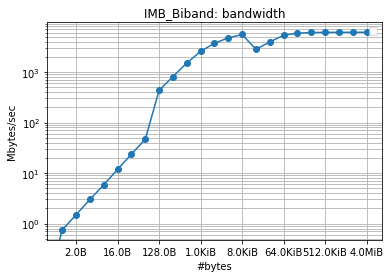

In [4]:
# Plotting:

from matplotlib import ticker

PLOTS = [
    {
        'test':'IMB_PingPong',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },
    {
        'test':'IMB_PingPong',
        'xaxis':'#bytes',
        'yaxis':'t[usec]',
        'metric':'latency',
    },
    {
        'test':'IMB_Uniband',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },
    {
        'test':'IMB_Biband',
        'xaxis':'#bytes',
        'yaxis':'Mbytes/sec',
        'metric':'bandwidth',
    },   
]

for plot in PLOTS:
    
    cases = test_results[plot['test']]
    
    # add a label to each case based on unique metadata:
    common, differences = modules.utils.diff_meta(cases) # NB if only 1x case differences => [{}]
#     print('common:')
#     pprint(common)
    for ix, unique_meta in enumerate(differences):
        label = '-'.join(str(v) for v in list(unique_meta.values()))
        cases[ix]['label'] = label
    
    # sort cases by label:
    cases = sorted(cases, key=lambda c: c['label'])
    
    fig, ax = plt.subplots()
    for ix, case in enumerate(cases):
        
        data = case['data'] # TODO: change this cope with benchmark name in output instead of fixed "data" key
        
        #plt.plot(data[plot['xaxis']], data[plot['yaxis']], 'o-', label=label)
        plt.plot(data[plot['xaxis']], data[plot['yaxis']], 'o-', label=case['label'])
        plt.grid()
        plt.title('%s: %s' % (plot['test'], plot['metric']))
        plt.legend()
        ax = plt.gca()
        ax.set_xscale('log', basex=2)
        ax.set_yscale('log', basey=10)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
        plt.grid(True, which="both")
        plt.xlabel(plot['xaxis'])
        plt.ylabel(plot['yaxis'])
    

In [5]:
# example of loading test objects - don't actually need this yet

# def get_tests(module):
#     tests = []
#     for name in dir(module):
#         obj = getattr(module, name)
#         if isinstance(obj, reframe.core.meta.RegressionTestMeta):
#             tests.append(obj)
#     return tests
# testobjs = get_tests(reframe_imb)
# print(testobjs)

In [6]:
# Load performance records
perf_records = modules.utils.load_perf_logs('../perflogs', 'IMB', '.log')
perf_records.reindex()
print('loaded %s performance records' % len(perf_records))
print(perf_records.index)

loaded 17 performance records
RangeIndex(start=0, stop=17, step=1)


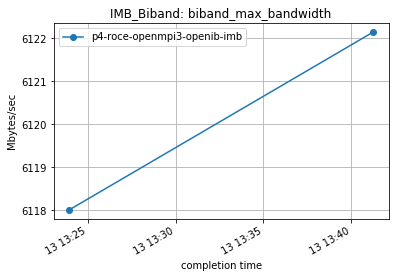

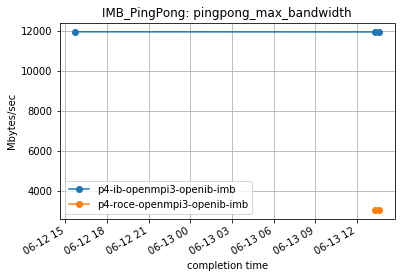

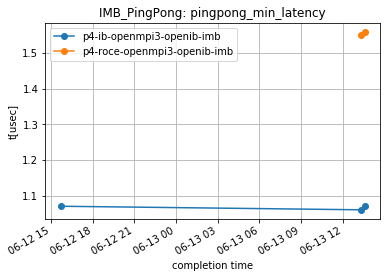

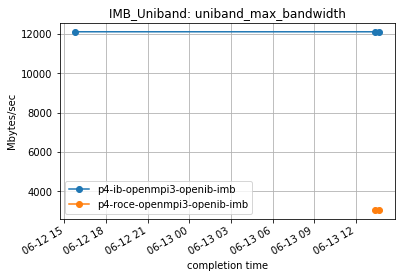

In [7]:
# Plot performance history:
modules.plots.plot_perf_history(perf_records)